In [25]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_train = pd.read_csv('D:/Summer-Analytics-2025/hacktrain.csv')
df_test = pd.read_csv('D:/Summer-Analytics-2025/hacktest.csv')

In [6]:
df_train = df_train.drop(columns=["Unnamed: 0", "ID"])
df_test_ids = df_test["ID"]  # Save for submission
df_test = df_test.drop(columns=["Unnamed: 0", "ID"])

In [7]:
X_raw = df_train.drop(columns=["class"])
y_raw = df_train["class"]


In [8]:
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X_raw)
X_test_imputed = imputer.transform(df_test)

In [9]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)

In [10]:
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_map)

Label Mapping: {'farm': 0, 'forest': 1, 'grass': 2, 'impervious': 3, 'orchard': 4, 'water': 5}


In [11]:
X_df = pd.DataFrame(X_imputed, columns=X_raw.columns)
X_test_df = pd.DataFrame(X_test_imputed, columns=df_test.columns)

In [12]:
def create_statistical_features(df):
    df_stats = pd.DataFrame()
    df_stats["ndvi_mean"] = df.mean(axis=1)
    df_stats["ndvi_std"] = df.std(axis=1)
    df_stats["ndvi_min"] = df.min(axis=1)
    df_stats["ndvi_max"] = df.max(axis=1)
    df_stats["ndvi_median"] = df.median(axis=1)
    df_stats["ndvi_range"] = df_stats["ndvi_max"] - df_stats["ndvi_min"]
    return pd.concat([df, df_stats], axis=1)

In [13]:
X_features = create_statistical_features(X_df)
X_test_features = create_statistical_features(X_test_df)

In [26]:
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)
X_test_features_scaled = scaler.transform(X_test_features)

In [37]:
X_features_scaled_df = pd.DataFrame(X_features_scaled, columns=X_features.columns)
X_test_scaled_df = pd.DataFrame(X_test_features_scaled, columns=X_test_features.columns)

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X_features_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


In [52]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'penalty': ['l2'],
    'multi_class': ['multinomial'],
    'max_iter': [1000]
}

In [53]:
lr = LogisticRegression()
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [1000],
                         'multi_class': ['multinomial'], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'saga']},
             scoring='accuracy')

In [54]:
best_model = grid_search.best_estimator_
val_preds = best_model.predict(X_val)

In [55]:
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("\nClassification Report:\n", classification_report(y_val, val_preds, target_names=label_encoder.classes_))

Validation Accuracy: 0.9075

Classification Report:
               precision    recall  f1-score   support

        farm       0.74      0.60      0.66       168
      forest       0.94      0.97      0.96      1232
       grass       0.85      0.59      0.70        39
  impervious       0.82      0.87      0.84       134
     orchard       1.00      0.17      0.29         6
       water       0.76      0.62      0.68        21

    accuracy                           0.91      1600
   macro avg       0.85      0.63      0.69      1600
weighted avg       0.90      0.91      0.90      1600



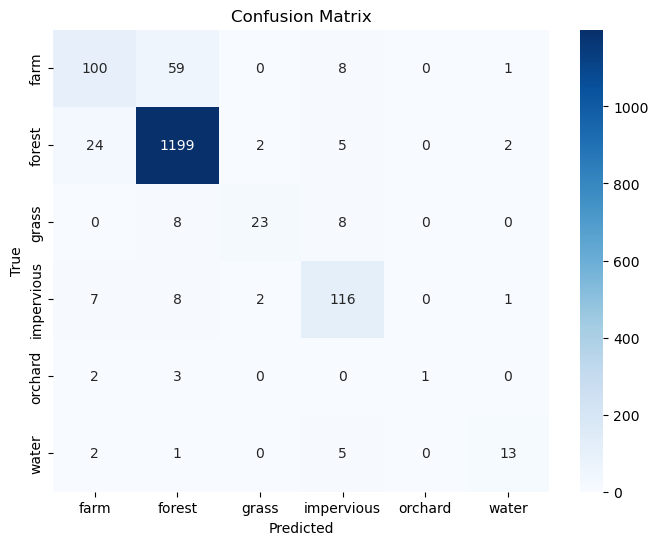

In [56]:
# 12. Confusion matrix
conf_matrix = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [57]:
# 13. Predict on test set
test_preds = best_model.predict(X_test_features)
test_labels = label_encoder.inverse_transform(test_preds)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [50]:
# 14. Prepare submission file
submission2 = pd.DataFrame({
    "ID": df_test_ids,
    "Predicted": test_labels
})

In [51]:
submission2.to_csv("submission2.csv", index=False)
print("Submission file created: submission2.csv")

Submission file created: submission2.csv
